Osnabrück University - Machine Learning (Summer Term 2018) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 09

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, June 10, 2018**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Independence) [2 Bonus Points]

This exercise is supposed to be very easy and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** Explain the idea of stochastical independence. What is the intuition and how is it defined?

Two variables are stochastical independent if they are not causally correlated. Their occurence is not dependent. If their joint probability equals the product of their marginal probabilities, they are assumed to be independent. $P(A\cap B) = P(A)*P(B)$.

**b)** What is pairwaise independence and what is mutual independence? Can you provide an example of variables that are pairwise independent but not mutual independent?

A set of events is pairwise independent if every pairing of events is independent. A set of events is mutual independent if every event is independent from any intersection of events. 

**c)** What does it mean that a variable is i.i.d.? When do we assume i.i.d. variables in machine learning and what are the consequences?

A variable is independent and identically distributed. It is assumed for basic statistics like z-test.

## Assignment 1: Self-Organizing Maps Theory [4 Points]

This exercise will highlight the theoretical differences of SOM's to other algorithms we already took a look at. There is again some research involved if the answers are not directly clear from the slides (or even better: your own ideas!)

### a) Learning in SOMs

How is learning in such a network achieved? Contrast this with to techniques used in MLP.

Learning is the competition of neurons for the best match. Those weights who best match get adapted and also their neighbours via lateral interaction. All neurons get the same input but the spatial arrangement of the neurons is crucial for learning. This leads to a topology perserving map. 
The competition is what is different to MLPs since there an overall error is computed and all weights are updated accrodingly where as in SOMs only the winner and its neighbours get updated.

### b) Initialization

Usually weights in a SOM are initialized randomly - what would be an alternative?

One could compute the largest principal components and sample data from the space spanned by these.

<a id="ex1c"></a>
### c) Decaying learning rate

When training a self organizing map (and also other complex models), it is recommended to use a decaying learning rate. Explain, how this affects the learning process and why it may be beneficial.

The following function is is often use for this purpose (where $s$ is the current training step and $S$ is the total number of steps to run):

$$\alpha(s, S) = 0.1 \exp\left(-\frac{s}{S-s}\right)$$

Plot its graph and discuss its properties.

A decaying learning rate is beneficial since at the beginning the intially random parameters are changed quickly towards meaningful values and at the end a small learning rate makes sure that the local minimum is not missed.

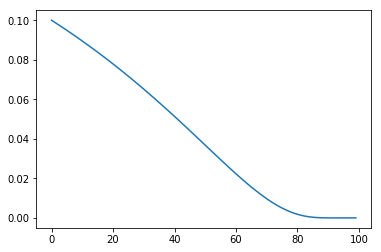

In [38]:
import numpy as np
import matplotlib.pyplot as plt
a = lambda s,S: 0.1*np.exp(-s/(S-s))
S = 100
s = np.arange(S)

plt.figure('Decaying learning rate')
plt.plot(s,a(s,S))
plt.show()

<a id="ex1d"></a>
### d) Decaying neighborhood function

SOM use a decaying neighborhood function. Explain its role in the training process.

One possible formula for for such a function is the following: let $u$ denote the coordinates of the best matching node, and $v$ the coordinates of some arbitrary node, $n$ the maximum number of nodes in one direction, and let a $s$ and $S$ again be the current step and the total number of steps, respectively: 

\begin{align*}
  r &= n \exp\left( -\frac{s \log(n)}{S} \right) \\
  \theta(u, v, s, S) &= \exp\left(-\frac{||u - v||^2}{2r^2}\right)
\end{align*}

Plot its 3D graph for a fixed node $u$ and describe its properties.

The neighbourhood function determines how strong neighbours of the winning unit are updated. A decaying function makes sure that at the beginning many neurons are moved towards the correct weight and later only small changes should be made.



<IPython.core.display.Javascript object>


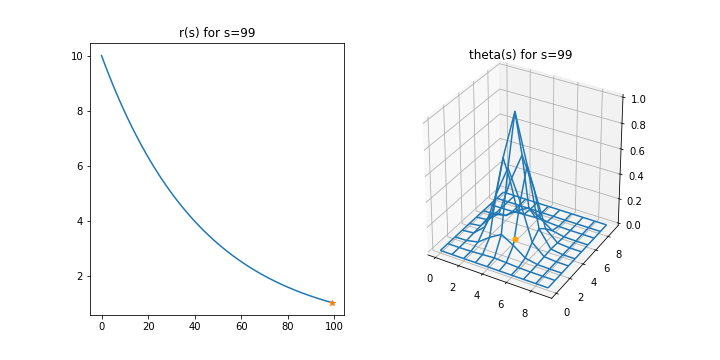

<IPython.core.display.Javascript object>


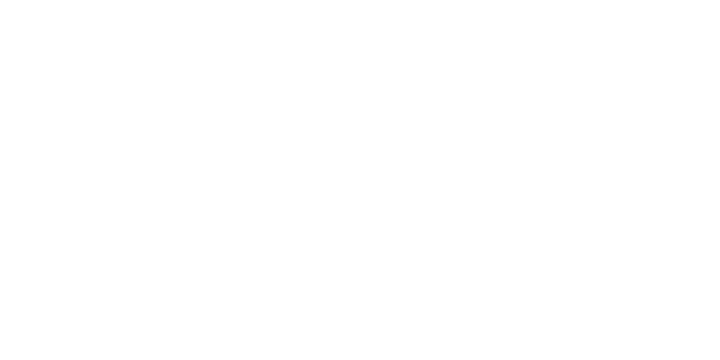

In [39]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# The reference point u
u = (4,4)

# The total number of steps
S = 100

# The size of the map (n*n)
n = 10

# the r function
r = lambda n,s,S: n * np.exp(-s*np.log(n)/S)

# the theta function
theta = lambda u,v,s,S : np.exp(-((u-v)**2).sum(2)/(2*r(n,s,S)**2))

v = np.indices((n,n)).transpose((1,2,0))
s_range = np.arange(S)

fig = plt.figure("The theta(u,v,s,S)", figsize = (10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

for s in s_range:
    ax1.cla()
    ax1.set_title("r(s) for s={}".format(s))
    ax1.plot(s_range,r(n,s_range,S), '-')
    ax1.plot(s,r(n,s,S),'*')

    ax2.cla()
    ax2.set_title("theta(s) for s={}".format(s))
    ax2.set_zlim3d(0,1)
    ax2.plot([u[0]], [u[1]], zs=[0], marker='o', color='orange', markersize=5)
    ax2.plot_wireframe(v[:,:,0],v[:,:,1],theta(u,v,s,S))

    fig.canvas.draw()

## Assignment 2: Self-Organizing Maps [6 Points]

In this exercise you will implement a self-organizing map and use it for a beautiful application: coloring countries having similar statistics in similar colors. 

### Additional Information about the Data

The data is taken from the [World Bank's World DataBank](http://databank.worldbank.org/data/home.aspx) and preprocessed. Since their data is very sparse we just tried to use the latest possible data for each country in each category. This means there can be data from the 1960 but also from 2015 - for the exercise this shouldn't matter too much. Note that some countries don't have data at all.

The [blank map](https://en.wikipedia.org/wiki/File:BlankMap-World6-Equirectangular.svg) is taken from wikipedia. It is an [SVG](https://en.wikipedia.org/wiki/Scalable_Vector_Graphics) file which suits this task well: We can easily display it in Jupyter Notebooks and it is very easy to color them, as this just involves a modification of their style sheet. You can find the code to do this below, you just have to figure out how to use it.

### Coloring the Map

The following cell defines a method to create a colored version of the empty map and shows an example usage of it.

As you can see, the mapping parameter is a dictionary mapping lowercase [ISO 3166-2](https://en.wikipedia.org/wiki/ISO_3166-2) country codes to `[R, G, B]` values which range from `0` to `1`.

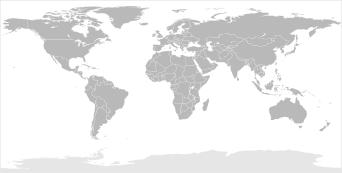

In [40]:
from IPython.display import SVG, display_svg
from xml.etree import cElementTree as ET
import time

def create_colored_map(color_mapping, scaling=0.7, display=True):
    """
    Takes a color mapping to create a world map with the specified 
    colors.
    For example:
    
    mapping = {'de': [1, 0, 0],
               'fr': [0, 1, 0]}
    create_and_display_colored_map(mapping)
    
    will create a worldmap and display it with Germany ('de') 
    colored red and France ('fr') colored green.
    Colors need to be iterables containing R G B values ranging
    from 0 (dark) to 1 (bright).
    
    The template used for the map can be found here:
    https://en.wikipedia.org/wiki/File:BlankMap-World6-Equirectangular.svg
    
    Args:
        mapping     A color mapping between country codes and colors.
        scaling     Scales the map by this factor. 
        display     If True, the image is displayed, if False, it is
                    returned.
    Returns:
        The svg image if display=False. Else nothing.
    """
    def color_css(color_mapping, map_id):
        """Creates a CSS string for the color mapping."""
        tmpl = '#{4} .{0} {{fill: #{1:0>2x}{2:0>2x}{3:0>2x} !important;}}'
        scale = lambda x : [int(255 * i) for i in x]
        return '\n' + '\n'.join([tmpl.format(country.lower(), *scale(color), map_id) for country, color in color_mapping.items()])

    # Read SVG file and get document root.
    tree = ET.parse('map.svg')
    root = tree.getroot()
    
    # Adjust the ID (Otherwise coloring will be global for all SVG images).
    time.sleep(1)
    root.attrib['id'] = "{}{}".format(root.attrib['id'], str(time.time())[0:10])
    
    # Search the style element and append the color mapping.
    style_element = tree.find('{http://www.w3.org/2000/svg}style')
    style_element.text = style_element.text + color_css(color_mapping, root.attrib['id'])

    # Adjust the image scale.
    root.attrib['height'] = str(float(root.attrib['height']) * scaling)
    root.attrib['width'] = str(float(root.attrib['width']) * scaling)
    
    # Create an SVG instance which can be displayed by Jupyter.
    svg = SVG(data=ET.tostring(root).decode('UTF-8').replace('ns0:',''))
    if display:
        display_svg(svg)
    else:
        return svg

# Example for coloring the map.
mapping = {'de': [1, 0, 0], 
           'fr': [0, 1, 0], 
           'us': [0, 0, 1]}
create_colored_map(mapping, scaling=0.4)

### a) Implement a Self-Organizing Map.

Below is a class definition for a self-organizing map. The initialization is already provided. Follow the instruction below to finish it.

1. Write a method `get_best_matching_index(self, X)` which returns the indices of the node with the weights closest to `X`. Use the `cdist` function to calculate the distances between `X` and all nodes. *Note:* You might need `unravel_index`.

1. Write a method `alpha(self, step, max_steps)` which defines the decaying learning rate. Use the formula from [exercise 1c)](#ex1c), i.e.
$$\alpha(s, S) = 0.1 \exp\left(-\frac{s}{S-s}\right)$$

1. Write a method `theta(self, u, v, step, max_steps)` which defines the decaying neighborhood function. Use the formula from [exercise 1d)](#ex1d), i.e,
$$\theta(u, v, s, S) = \exp\left(-\frac{||u - v||^2}{2r^2}\right)\qquad\text{with }
  r = n \exp\left( -\frac{s \log(n)}{S} \right) $$

1. Write a function `organize(self, max_steps)` which trains the map for `max_steps` steps. Pick a random data sample $X$, calculate the best matching indices $u$ and update each node $v_i$ (with $w_{v_i}$ being the corresponding weight vector) according to the following formula ($s$, $S$, $\theta$ and $\alpha$ are as above): 
$$\Delta w_{v_i} = \theta(u, v_i, s, S)\ (X - w_{v_i})\ \alpha(s, S)$$

In [41]:
%matplotlib inline
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

class SelfOrganizingMap:
    """Implements a self-organizing map."""
    
    def __init__(self, data, map_size=(20,20), method='distance'):
        """
        Creates a grid self.nodes of map_size[0] x map_size[1] 
        many nodes with random weights for each dimension in the 
        data. This means self.nodes.shape will be 
        (map_size[0], map_size[1], data.shape[-1]).
        
        Stores the data in self.data.
        
        Args:
            data        The data to fit with this map.
            map_size    The size of the map. Defaults to 20x20.
            method      The activation method. Supports 'distance' and 'activation'.
        """
        self.nodes = np.random.rand(map_size[0], map_size[1], data.shape[-1])
        self.data = data
        self.method = method
    
    def theta(self, u, v, step, max_steps):
        """
        The neighborhood function. 
        
        Args:
            u           The best matching node's grid coordinates.
            v           Grid coordinates of the (possible) neighboring node.
            step        The current step.
            max_steps   The maximum number of steps.
        
        Returns:
            A weight of how strong the neighborhood relation between
            u and v is at step of max_steps.
        """
        #maximum number of nodes
        n = max(self.nodes.shape[:2])
        #compute r
        r = n*np.exp(-(step*np.log(n))/max_steps)
        #return neighbourhood relation of u and v at current step
        return np.exp(-np.linalg.norm(u-v)**2/(2*r**2))

    def alpha(self, step, max_steps):
        """
        The learning rate. Decays with step.
        
        Args:
            step        The current step.
            max_steps   The maximum number of steps.
        """
        return 0.1 * np.exp(-step/(max_steps-step))

    def organize(self, max_steps):
        """
        For steps this method organizes the map with its data.
        
        In each step it picks a random sample from the data and
        calculates the best matching node.
        The best matching node's indices are calculated with 
        get_best_matching_index.
        Using the indices of that node, all nodes are
        updated by applying alpha and theta.
        
        Args:
            max_steps   The number of steps.
        """
        for step in range(max_steps):
            #get random data sample
            X = self.data[np.random.randint(len(self.data))]
            #best match
            u = self.get_best_matching_index(X)
            #go through neighbours and update
            for row in range(self.nodes.shape[0]):
                for col in range(self.nodes.shape[1]):
                    theta = self.theta(u,np.array([row,col]),step,max_steps)
                    alpha = self.alpha(step,max_steps)
                    #update rule
                    self.nodes[row,col] += theta * (X-self.nodes[row,col]) * alpha
    
    def get_best_matching_index(self, X):
        """
        Calculates the best matching node for data sample X.
        Depending on the method used (see __init__), a different
        approach is used.
        
        method 'distance': 
            Finds the best matching node by minimal distance:
                argmin(||n-x||)
        other method ('activation'): 
            Finds the best matching node by maximal excitation:
                argmax(nx)
        
        Args:
            X       The data point.
        Returns:
            The grid coordinates of the best matching node.
        """
        # reshape nodes such that 
        flat = self.nodes.reshape(-1,self.nodes.shape[-1])
        
        if self.method == 'distance':
            #calculate all distances between data point and nodes
            distances = cdist(X[np.newaxis],flat)
            best = np.argmin(distances)
            
        else:
            #calculate activations
            activations = np.sum(np.multiply(X[np.newaxis], flat), 1)
            best = np.argmax(activations)
        return np.array(np.unravel_index(best, self.nodes.shape[:2]))
            

    def __getitem__(self, key):
        """
        Allows to access the nodes via the self-organizing map directly.
        
        som[4,2] 
        is thus same as 
        som.nodes[4,2]
        
        Args:
            key The key (can be a slice or similar).
        Returns:
            self.nodes[key]
        """
        return self.nodes[key]

    def plot(self):
        """Plots the map's first three features as an image."""
        plt.imshow(self.nodes[:,:,0:3], interpolation='none')

### b) Apply the Self-Organizing Map

Now apply your self-organizing map on some data.

We already generate simple color data for you - you can change it if you like.

1. Load `world_data.csv`. We recommend using a `csv.reader` for this, as the first column contains strings: the labels you need to use to accomplish the mapping.

1. The data has some invalid values (np.nan). Use the `Imputer` (check the imports) to fill them.

1. Additionally the data has to be scaled. Use `scale` (check the imports) for this.

1. Create two instances of the `SelfOrganizingMap` and organize them, one for the colors and one for the countries. Take care that both have the same sizes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


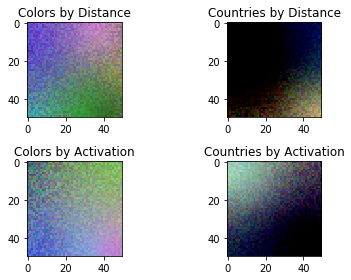

In [42]:
%matplotlib inline
import csv
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer as Imputer, scale as scale

# Generate color data.
colors = np.array(list(itertools.product([0, 1], repeat=3)))

# TODO: Read world data.
with open('world_data.csv','r') as file:
    data = list(csv.reader(file))[1:]
##country names as strings
countries = np.array([d[:2] for d in data], dtype = 'str_')
##country data with filled missing values and scaled
country_data = np.array([d[2:] for d in data], dtype = 'float_')
imp = Imputer(np.nan, copy=False)
imp.fit_transform(country_data)
country_data = scale(country_data, axis = 0)

# TODO: Create color map and organize it.
# define map size and maximal step number
size = (50,50)
max_steps = 100
som_colors = SelfOrganizingMap(colors, size)
som_colors.organize(max_steps)
som_colors_act = SelfOrganizingMap(colors, size, method = 'activation')
som_colors_act.organize(max_steps)

# TODO: Create country map and organize it.
som_countries = SelfOrganizingMap(country_data, size)
som_countries.organize(max_steps)
som_countries_act = SelfOrganizingMap(country_data, size, method = 'activation')
som_countries_act.organize(max_steps)

# Take a look at the results.
plt.figure('SOM')
plt.subplot(221).set_title('Colors by Distance')
som_colors.plot()
plt.subplot(222).set_title('Countries by Distance')
som_countries.plot()
plt.subplot(223).set_title('Colors by Activation')
som_colors_act.plot()
plt.subplot(224).set_title('Countries by Activation')
som_countries_act.plot()
plt.tight_layout()

Select the best matching indices for each country from the country map. Use those indices to select the corresponding color from the color map. Create the mapping from ISO codes to colors and use the `create_colored_map` function to produce the colored SVG map.

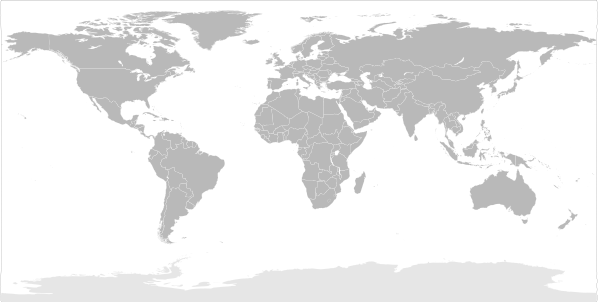

In [43]:
# TODO: Match countries to colors.
mapping = {}
for i, data in enumerate(country_data):
    x,y = som_countries.get_best_matching_index(data)
    mapping[countries[i,1]] = som_colors[x,y]

# TODO: Create colored map.
create_colored_map(mapping)

## Assignment 3: Probability Theory [4 Points]

Consider three bags filled with three types of candy. The table below indicates for each bag how many candies of each type are in each bag.

| contains        || green candy | blue candy | red candy || total |
|-----------------||-------------|------------|-----------||-------|
|                 ||             |            |           ||       |
| **cyan bag**    ||          10 |          4 |         2 ||    16 |
| **magenta bag** ||           5 |          7 |         2 ||    14 |
| **yellow bag**  ||           2 |          2 |         8 ||    12 |
|                 ||             |            |           ||       |
| **total**       ||          17 |         13 |        12 ||    42 |

In the following we denote the bags as $B=\{c,m,y\}$ and the candies as $C=\{r, g, b\}$. So the probability for drawing a blue candy from the cyan bag would be: $P(C=b|B=c)=\frac{4}{16}=0.25$.

### a)

Give a verbal description of the following events and compute their probabilities:
$$
\begin{align*}
P(C=b|B=m) &= ? \\
P(C=g|B=y) &= ? \\
\end{align*}
$$

Given that we draw from the magenta bag how likely is it that we get blue candy? $P(C=b|B=m) = \frac{7}{14} = 0.5$.

Given that we draw from the yellow bag how likely is it to get green candy? $P(C=g|B=y) = \frac{2}{12} = \frac{1}{6}$.

### b)

Now assume that you randomly choose bag and then randomly draw a candy from that bag. What is the probability that the candy is red?

$$P(C=r) = ?$$

$P(C=r) = \frac{1}{3}*(\frac{2}{16}+\frac{2}{14}+\frac{8}{12}) = 0.312$

### c)

Someone has choosen a red candy from one of the bags, but does not tell you from which bag it originated.
Compute the probability that it was from the yellow bag:
    
$$P(B=y|C=r) = ?$$

$P(B=y|C=r)=\frac{P(r|y)*P(y)}{P(r)}=\frac{\frac{8}{12}*\frac{1}{3}}{0.312}=0.712$

### d) 

Let's assume we draw with the following probabilities from each bag: $P(B=c)=0.2$, $P(B=m)=0.7$, $P(B=y)=0.1$.
What are the probabilities to draw a green, blue or red candy?

$P(C=g) = \sum\limits_{x\in B}{P(x)*P(g|x)} = 0.2 *\frac{10}{16} + 0.7*\frac{5}{14}+0.1*\frac{2}{12} = 0.392$

$P(C=b) = \sum\limits_{x\in B}{P(x)*P(b|x)} = 0.2 *\frac{4}{16} + 0.7*\frac{7}{14}+0.1*\frac{2}{12} = 0.417$

$P(C=r) = \sum\limits_{x\in B}{P(x)*P(r|x)} = 0.2 *\frac{2}{16} + 0.7*\frac{2}{14}+0.1*\frac{8}{12} = 0.192$

## Assignment 4: Bayes classifier [6 Points]

Consider the following data set. There are four features, running nose ($N$), coughing ($C$), reddened skin ($R$), and fever ($F$), each of which can take the values true ($+$) or false ($-$).

| Diagnosis ID  | $N$ | $C$ | $R$ | $F$ | Classification     |
|---------------|-----|-----|-----|-----|--------------------|
|     $d_1$     | $+$ | $+$ | $+$ | $-$ | positive (ill)     |
|     $d_2$     | $+$ | $+$ | $-$ | $-$ | positive (ill)     |
|     $d_3$     | $-$ | $-$ | $+$ | $+$ | positive (ill)     |
|     $d_4$     | $+$ | $-$ | $-$ | $-$ | negative (healthy) |
|     $d_5$     | $-$ | $-$ | $-$ | $-$ | negative (healthy) |
|     $d_6$     | $-$ | $+$ | $+$ | $-$ | negative (healthy) |

Solve the following problems either by hand or programmatically. Assume all features are independent.

### a)

Determine all probabilities required to apply a Bayes classifier for predicting whether a new person is ill or not.

$P(ill) = \frac{1}{2}$;
$P(healthy) = \frac{1}{2}$

$P(N) = \frac{3}{6} = \frac{1}{2}$;
$P(N|ill)= \frac{2}{3}$;
$P(N|healthy)= \frac{1}{3}$

$P(C) = \frac{3}{6} = \frac{1}{2}$;
$P(C|ill)= \frac{2}{3}$;
$P(C|healthy)= \frac{1}{3}$

$P(R) = \frac{3}{6} = \frac{1}{2}$;
$P(R|ill)= \frac{2}{3}$;
$P(R|healthy)= \frac{1}{3}$

$P(F) = \frac{1}{6}$;
$P(F|ill)= \frac{1}{3}$;
$P(F|healthy) = \frac{0}{3}=0$

$P(\neg X) = 1-P(X)$


### b)
Person $p_1$ is coughing and has fever. Person $p_2$ has a running nose and reddened skin. Person $p_3$ is coughing, sufferes from reddened skin and has fever. Determine the probability of being ill for all persons $p1, p2, p3$.

$P(A|B) = \frac{P(B|A)*P(A)}{(P(B|A)*P(A)) + P(B|\neg A)*P(\neg A)}$

$P(ill|\neg N,C,\neg R,F) = \frac{(\frac{1}{3}*\frac{2}{3}*\frac{1}{3}*\frac{1}{3})*\frac{1}{2}}{(\frac{1}{3}*\frac{2}{3}*\frac{1}{3}*\frac{1}{3})*\frac{1}{2} + (\frac{1}{3}*\frac{2}{3}*\frac{1}{3}*0)*\frac{1}{2}} = 1$

$P(ill|N,\neg C,R,\neg F) = \frac{(\frac{2}{3}*\frac{1}{3}*\frac{2}{3}*\frac{2}{3})*\frac{1}{2}}{(\frac{2}{3}*\frac{1}{3}*\frac{2}{3}*\frac{2}{3})*\frac{1}{2} + (\frac{1}{3}*\frac{2}{3}*\frac{1}{3}*1)*\frac{1}{2}} = \frac{4}{7}$

$P(ill|\neg N,C,R,F) = \frac{(\frac{1}{3}*\frac{2}{3}*\frac{2}{3}*\frac{1}{3})*\frac{1}{2}}{(\frac{1}{3}*\frac{2}{3}*\frac{2}{3}*\frac{1}{3})*\frac{1}{2} + (\frac{2}{3}*\frac{1}{3}*\frac{1}{3}*0)*\frac{1}{2}} = 1$